In [1]:
!pip install transformers jaconv neologdn fugashi ipadic mecab-python3 unidic-lite

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.4 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.3/613.3 kB 6.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 20.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.5/581.5 kB 8.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 18.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for jaconv: filename=jaconv-0.3.4-py3-no

# Libraries

In [4]:
import logging
import os, sys
import pandas as pd
import numpy as np
import random
import numpy as np
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertForSequenceClassification
from transformers.optimization import get_cosine_schedule_with_warmup, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix,roc_auc_score,roc_curve,classification_report
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
torch.cuda.device_count()

4

In [6]:
os.environ['CUDA_VISIBLE_DEVICES']="0,1,2,3"

# Parameters

In [7]:
def get_config(args=None):
    parser = argparse.ArgumentParser(
        description="classificationBertAE")
    
    parser.add_argument('--bert_model_path', type=str, default='cl-tohoku/bert-large-japanese')
    parser.add_argument('--output_path', type=str, default="./output/classificationBertAE-GPUParallel")
    parser.add_argument('--input_data', type=str, default='./output/ae_dataset.csv')
    parser.add_argument('--device', default = "cuda" if torch.cuda.is_available() else "cpu", type=str)
    parser.add_argument('--device_count', default = torch.cuda.device_count() if torch.cuda.is_available() else 0, type=int)
    
    parser.add_argument('--batch_size', default=64, type=int)    
    parser.add_argument('--epoch_num', default=10, type=int)    
    parser.add_argument('--learning_rate', default=3e-5, type=float)
    parser.add_argument('--weight_decay', default=0.01, type=float)
    parser.add_argument('--clip_grad', default=5, type=int)  
    
    config = parser.parse_args(args=[])

    config.device = torch.device(config.device)
    
    return config

In [8]:
config = get_config() 

# Input data

In [12]:
df_data = pd.read_csv(config.input_data)

df_data.columns = ['row', 'word', 'label']

# ラベルの二値化
df_data['label'] = df_data['label'].apply(lambda x: 1 if x else 0)

# Holdout
df_train_val, df_holdout = train_test_split(df_data, test_size=0.1, stratify=df_data['label'])

# 学習データとテストデータ
df_train_val = df_train_val.drop_duplicates(['row', 'label']) # ラベルの数を合わせてデータを減らす
df_train, df_val = train_test_split(df_train_val, test_size=0.1, stratify=df_train_val['label'])

print('df_holdout',df_holdout.value_counts('label'),'\n')
print('df_train',df_train.value_counts('label'),'\n')
print('df_val',df_val.value_counts('label'),'\n')

#os.makedirs(config.output_path)
df_holdout.to_csv(f'{config.output_path}/df_holdout.csv', index=False)
df_train.to_csv(f'{config.output_path}/df_train.csv', index=False)
df_val.to_csv(f'{config.output_path}/df_val.csv', index=False)

df_holdout label
1    4050
0    1047
dtype: int64 

df_train label
0    32796
1     8482
dtype: int64 

df_val label
0    3644
1     943
dtype: int64 



# Dataset

In [6]:
tokenizer = BertJapaneseTokenizer.from_pretrained(config.bert_model_path)

In [10]:
df_train['row_tokens'] = df_train['row'].apply(lambda x: tokenizer.tokenize(x))
df_train['word_tokens'] = df_train['word'].apply(lambda x: tokenizer.tokenize(x))
df_train['encode'] = df_train.apply(
    lambda x: tokenizer.encode_plus(x['row_tokens'] ,x['word_tokens'], padding='max_length', max_length=128, is_pretokenized=True, truncation='only_first',), axis=1)

In [11]:
df_val['row_tokens'] = df_val['row'].apply(lambda x: tokenizer.tokenize(x))
df_val['word_tokens'] = df_val['word'].apply(lambda x: tokenizer.tokenize(x))
df_val['encode'] = df_val.apply(
    lambda x: tokenizer.encode_plus(x['row_tokens'] ,x['word_tokens'], padding='max_length', max_length=128, is_pretokenized=True, truncation='only_first',), axis=1)

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df_encode, labels, config):
        self.df_encode = df_encode
        self.labels = labels
        self.config = config
    def __getitem__(self, idx):
        item = {col: torch.tensor(self.df_encode[col].to_list()[idx]).to(self.config.device) for col in self.df_encode.columns}
        item['labels'] = torch.tensor(self.labels[idx]).to(self.config.device)
        return item

    def __len__(self):
        return len(self.labels)

In [8]:
train_dataset = Dataset(pd.DataFrame(df_train['encode'].to_list()), df_train['label'].to_list(), config)
val_dataset = Dataset(pd.DataFrame(df_val['encode'].to_list()), df_val['label'].to_list(), config) 

training_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False) 

# Train

In [12]:
def train_epoch(model, config, epoch_idx, training_dataloader, optimizer,scheduler):
    
    # model ==> train mode
    model.train()
    train_losses = 0
    for batch_id, batch in enumerate(tqdm(training_dataloader)):    

        input_ids, attention_mask, token_type_ids,label=batch['input_ids'], batch['attention_mask'], batch['token_type_ids'],batch['labels']
        
        # forward pass
        outputs=model(input_ids,attention_mask,token_type_ids,labels = label)
        
        loss=outputs.loss
        #print(loss)
        loss=loss.mean()

        #print(loss.size())
        train_losses += loss.item() 
        
        # grad update      
        model.zero_grad()
        loss.backward()
        
        # clip_grad
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=config.clip_grad)
        
        # grad calculate
        optimizer.step()
        scheduler.step()
        
    train_loss = float(train_losses) / len(training_dataloader)
    logging.info(f"Epoch: {epoch_idx}, train loss: {train_loss}")
    print(f"Epoch: {epoch_idx}, train loss: {train_loss}")

In [13]:
def train(model,training_dataloader,validation_dataloader,optimizer,scheduler,config):
    
    best = 0.0
    
    true_labels=[]
    pred_labels=[]
    
    for epoch_idx in range(1, config.epoch_num + 1):    
        print("epoch {}/{}".format(epoch_idx, config.epoch_num))
        
        # Train
        train_epoch(model, config, epoch_idx, training_dataloader, optimizer,scheduler)

        # Validate
        print('Validate')
        logging.info("Start validation")
        val_f1,auc,recall=validate(model,validation_dataloader)
        
        # save model with highest F1 score
        if auc>best:
            best=auc
            # save model
            torch.save(model.module, os.path.join(config.output_path,"model_llt.pth"))
            logging.info("--------Save best model--------")
            print("--------Save best model--------")            
            
    logging.info("Training Finished")         
    print("Training Finished")

In [14]:
def validate(model,validation_dataloader):
    
    # model ==> eval mode
    model.eval()
    val_losses = 0
    true_labels=[]
    pred_labels=[]
    pred_values=[]
    for batch_id, batch in enumerate(tqdm(validation_dataloader)):        
        input_ids, attention_mask, token_type_ids,label=batch['input_ids'], batch['attention_mask'], batch['token_type_ids'],batch['labels']
        with torch.no_grad():
            outputs=model(input_ids,attention_mask,token_type_ids)

            #print(outputs)
            m = torch.nn.Softmax(dim=1)
            o_args = m(outputs.logits)[:,1].tolist()
            preds=[1 if i > 0.5 else 0 for i in o_args ]            
            labels=label.tolist()
            
            pred_labels+=preds
            true_labels+=labels
            pred_values+=o_args
            
    #print(len(pred_labels))    
    #print(len(true_labels))     
    display(pd.DataFrame(confusion_matrix(true_labels, pred_labels)))
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=2*precision*recall/(precision+recall)
    auc = roc_auc_score(true_labels,pred_values)
    
    print('precision:',precision)
    print('recall:',recall)    
    print('f1:',f1)  
    print('auc:',auc) 
    
    logging.info(f"precision: {precision}, recall: {recall}, f1: {f1}, auc: {auc}")
    
    df=pd.DataFrame({'label':true_labels,'pred':pred_values})
    sns.distplot(df[df['label']==1]['pred'], bins=20,label="llt_true=1").set(title='Tohoku-classificationBERT_LLT')
    sns.distplot(df[df['label']==0]['pred'], bins=20,label="llt_true=0")
    plt.legend()
    plt.show()
    
    return f1,auc,recall

In [16]:
if __name__ == "__main__":
    #config = get_config() 

    logging.basicConfig(
        filename=os.path.join(config.output_path, "log_ae" + ".txt"), 
        filemode='w',
        level=logging.INFO, 
        format='[%(levelname)s]%(message)s', force=True)
    logging.info("PARAMETERS:")
    for arg in vars(config):
        logging.info("{0}: {1}".format(arg, getattr(config, arg)))
    logging.info("----------")      
    
    bert =BertForSequenceClassification.from_pretrained(config.bert_model_path,num_labels=2).to(config.device)
    bert = nn.DataParallel(bert)# , device_ids=[0,1,2,3]
    # Prepare optimizer    full_fine_tuning
    bert_optimizer = list(bert.module.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in bert_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': config.weight_decay},
        {'params': [p for n, p in bert_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, correct_bias=False)      

    # Dynamic learning rate adjustment
    train_steps_per_epoch = len(train_dataset) // config.batch_size
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                        num_warmup_steps=(config.epoch_num // 10) * train_steps_per_epoch, 
                                        num_training_steps=config.epoch_num * train_steps_per_epoch)

    logging.info("--------Start Training--------")
    train(bert,training_dataloader,validation_dataloader,optimizer,scheduler,config) 

epoch 1/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [23:39<00:00,  2.20s/it]


Epoch: 1, train loss: 0.19897369885051897
Validate


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]

5097
5097


,0,1
0,3952,98
1,153,894


precision 0.9012096774193549
recall 0.8538681948424068
epoch 2/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [23:42<00:00,  2.21s/it]


Epoch: 2, train loss: 0.12034345085826494
Validate


100%|██████████| 80/80 [01:25<00:00,  1.07s/it]

5097
5097


,0,1
0,3897,153
1,126,921


precision 0.8575418994413407
recall 0.8796561604584527
epoch 3/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [23:44<00:00,  2.21s/it]


Epoch: 3, train loss: 0.08252194589364899
Validate


100%|██████████| 80/80 [01:28<00:00,  1.10s/it]

5097
5097


,0,1
0,3936,114
1,122,925


precision 0.890279114533205
recall 0.8834765998089781
epoch 4/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [23:51<00:00,  2.22s/it]


Epoch: 4, train loss: 0.05748816234268999
Validate


100%|██████████| 80/80 [01:25<00:00,  1.07s/it]

5097
5097


,0,1
0,3904,146
1,86,961


precision 0.8681120144534779
recall 0.9178605539637058
epoch 5/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [24:10<00:00,  2.25s/it]


Epoch: 5, train loss: 0.04163205052785532
Validate


100%|██████████| 80/80 [01:27<00:00,  1.09s/it]

5097
5097


,0,1
0,3927,123
1,91,956


precision 0.8860055607043559
recall 0.9130850047755492
epoch 6/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [24:06<00:00,  2.24s/it]


Epoch: 6, train loss: 0.025555302093212506
Validate


100%|██████████| 80/80 [01:27<00:00,  1.10s/it]

5097
5097


,0,1
0,3928,122
1,74,973


precision 0.8885844748858448
recall 0.9293218720152817
epoch 7/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [23:41<00:00,  2.20s/it]


Epoch: 7, train loss: 0.017335076682919785
Validate


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]

5097
5097


,0,1
0,3952,98
1,86,961


precision 0.9074598677998111
recall 0.9178605539637058
epoch 8/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [24:12<00:00,  2.25s/it]


Epoch: 8, train loss: 0.010072243570451861
Validate


100%|██████████| 80/80 [01:28<00:00,  1.11s/it]

5097
5097


,0,1
0,3960,90
1,91,956


precision 0.9139579349904398
recall 0.9130850047755492
epoch 9/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [23:48<00:00,  2.22s/it]


Epoch: 9, train loss: 0.0059329842556360025
Validate


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]

5097
5097


,0,1
0,3959,91
1,92,955


precision 0.9130019120458891
recall 0.9121298949379179
epoch 10/10


  0%|          | 0/645 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 645/645 [24:11<00:00,  2.25s/it]


Epoch: 10, train loss: 0.0037495571389704555
Validate


100%|██████████| 80/80 [01:25<00:00,  1.07s/it]

5097
5097


,0,1
0,3959,91
1,95,952


precision 0.912751677852349
recall 0.9092645654250239
Training Finished


# Evaluation

In [14]:
os.environ['CUDA_VISIBLE_DEVICES']="0"

In [15]:
df_holdout = pd.read_csv(f'{config.output_path}/df_holdout.csv')

In [18]:
class ClasificationBertAE:
    def __init__(self, model_path, tokenizer_path, batch_size):
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path
        self.batch_size = batch_size
        self.device = self.init_device()
        self.tokenizer = self.init_tokenizer()
        self.model = self.init_model()
    
    def init_device(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return device

    def init_tokenizer(self):
        tokenizer = BertJapaneseTokenizer.from_pretrained(self.tokenizer_path)
        return tokenizer
    
    def init_model(self):
        model = torch.load(self.model_path).to(self.device)
        return model
    
    def inference(self, texts, words):
        # トークン化
        row_word_tokens = [(self.tokenizer.tokenize(text), self.tokenizer.tokenize(word)) for text, word in zip(texts, words)]
        preds = []
        for i in tqdm(range(0, len(row_word_tokens), self.batch_size)):
            with torch.no_grad():
                inputs = self.tokenizer.batch_encode_plus(
                    row_word_tokens[i:i+self.batch_size], 
                    return_tensors='pt', 
                    truncation='only_first', 
                    is_split_into_words=False,
                    padding='max_length', 
                    max_length=128
                ).to(self.device)
                outputs = self.model(**inputs)
                m = torch.nn.Softmax(dim=1)
                o_args = m(outputs.logits)
                o_args_array = o_args.to('cpu').detach().numpy().copy()
                preds += o_args_array[:,1].tolist()
                torch.cuda.empty_cache()
        return preds

In [20]:
tokenizer_path='cl-tohoku/bert-large-japanese'
model_path="./output/classificationBertAE-GPUParallel/model_ae.pth"
bert = ClasificationBertAE(model_path=model_path, tokenizer_path=tokenizer_path, batch_size=32)

In [21]:
df_holdout['pred'] = bert.inference(df_holdout['row'].to_list(), df_holdout['word'].to_list())

100%|██████████| 160/160 [01:39<00:00,  1.60it/s]


In [26]:
df_holdout['label']=df_holdout['label'].apply(lambda x: 1 if x==0 else 0)

**Histgram**

In [27]:
df_holdout

,row,word,label,pred,pred_label
0,G2白血球減少、G2好中球減少は回復。,白血球減少,1,0.999965,1
1,38.5°Cの発熱で予約外にて受診。GRADE3の薬剤性ILD(間質性肺疾患)発現し、入院。,GRADE3の薬剤性ILD(間質性肺疾患)発現し,0,0.000004,0
2,腫瘍増悪の転帰は不明。,腫瘍,0,0.000056,0
3,再診時に下血の症状あり、赤沈上昇あり、UC(潰瘍性大腸炎)悪化と診断、入院。,大腸炎,0,0.000128,0
4,貧血のため、リムパーザ錠200MG×2回/日に減量再開。,リムパーザ,0,0.000005,0
...,...,...,...,...,...
5092,難治性続発性気胸、脳転移、遅発性肺障害(重篤でない)の転帰は不明。,続発性気胸,0,0.000175,0
5093,HB:7.3、G3貧血発現。リムパーザ休薬。,HB:7,0,0.000005,0
5094,リムパーザ錠内服約15ヶ月(再開後3ヶ月)、HB:5.9にてGRADE3の貧血発現、輸血を実施。,輸血を実施,0,0.000005,0
5095,味覚異常(重篤でない)を理由にリムパーザ錠投与中止した。,リムパーザ,0,0.000005,0


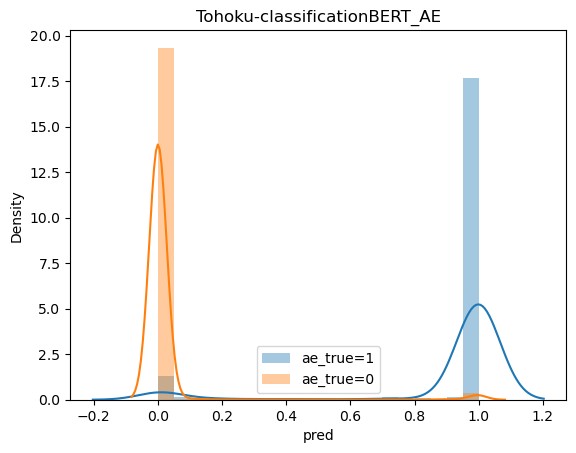

In [28]:
sns.distplot(df_holdout[df_holdout['label']==1]['pred'], bins=20,label="ae_true=1").set(title='Tohoku-classificationBERT_AE')
sns.distplot(df_holdout[df_holdout['label']==0]['pred'], bins=20,label="ae_true=0")
plt.legend()
plt.show()

**ROC-AUC**

In [29]:
# AUC
auc = roc_auc_score(df_holdout['label'], df_holdout['pred'])
print('auc:',auc)
# # ROC曲線の値の生成：fpr、tpr、閾値
fpr, tpr, thresholds = roc_curve(df_holdout['label'], df_holdout['pred'])

auc: 0.9887172049477048


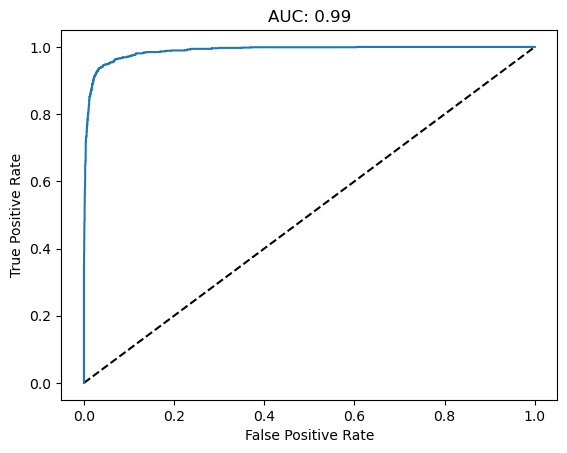

In [30]:
# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'AUC: {round(auc,2)}')
plt.show()

In [31]:
df_holdout['pred_label'] = df_holdout['pred'].apply(lambda x: 1 if x > 0.5 else 0)
tn, fp, fn, tp = confusion_matrix(df_holdout['label'], df_holdout['pred_label']).ravel()
print(f'tn:{tn}, fp:{fp}, fn:{fn}, tp:{tp}')
pd.DataFrame(confusion_matrix(df_holdout['label'], df_holdout['pred_label']))

tn:3959, fp:91, fn:95, tp:952


,0,1
0,3959,91
1,95,952


In [34]:
print(classification_report(df_holdout['label'], df_holdout['pred_label'], target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4050
           1       0.91      0.91      0.91      1047

    accuracy                           0.96      5097
   macro avg       0.94      0.94      0.94      5097
weighted avg       0.96      0.96      0.96      5097



In [35]:
df_holdout.head()

,row,word,label,pred,pred_label
0,G2白血球減少、G2好中球減少は回復。,白血球減少,1,0.999965,1
1,38.5°Cの発熱で予約外にて受診。GRADE3の薬剤性ILD(間質性肺疾患)発現し、入院。,GRADE3の薬剤性ILD(間質性肺疾患)発現し,0,0.000004,0
2,腫瘍増悪の転帰は不明。,腫瘍,0,0.000056,0
3,再診時に下血の症状あり、赤沈上昇あり、UC(潰瘍性大腸炎)悪化と診断、入院。,大腸炎,0,0.000128,0
4,貧血のため、リムパーザ錠200MG×2回/日に減量再開。,リムパーザ,0,0.000005,0


**output**

In [36]:
df_holdout.to_csv(f'{config.output_path}/validation_result.csv', index=False)